In [2]:
# This file plots the elevation gradients of bus route road segments with a
# red/blue diverging color map to indicate uphill (red) and downhill (blue)
# slopes.

In [2]:
from os import listdir
from rtree.index import Index as RTreeIndex
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from shapely.geometry import Point
from shapely.ops import snap
from tqdm import tqdm
import geopandas as gpd
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy as npm
import osmnx as ox
import pandas as pd
import re
import shapely

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [4]:
def peek(df):
    print(len(df))
    display(df.iloc[0:3])

In [71]:
routes_gdf = gpd.read_file(f'{DATA_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp')
routes_gdf = routes_gdf.to_crs(CRS_LATLON)
routes_gdf = routes_gdf[routes_gdf['route_id'].str.startswith('M')]
peek(routes_gdf)

82


,route_id,route_dir,route_shor,route_long,color,geometry
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.95142 40.78518, -73.9518..."
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.99003 40.72960, -73.9899..."


In [72]:
route_ids = list(set(routes_gdf['route_id']))
route_ids = [f for f in route_ids if re.match('M\d+$', f)]
route_ids.sort()

In [73]:
for route_id in route_ids:
    routes_gdf[routes_gdf['route_id'] == route_id].to_file(
        f'{EXPORTS_DIR}/shp/manhattan/routes/{route_id}.shp')

In [15]:
stops_gdf = gpd.read_file(f'{DATA_DIR}/shp/manhattan/bus_stops_nyc_may2020.shp')
stops_gdf = stops_gdf.to_crs(CRS_LATLON)
stops_gdf = stops_gdf[stops_gdf['NAMELSAD'] == 'New York County']
peek(stops_gdf)

1950


,stop_id,stop_name,stop_lat,stop_lon,GEOID,NAMELSAD,geometry
0,400001,4 AV/E 10 ST,40.731342,-73.990292,36061,New York County,POINT (-73.99029 40.73134)
1,400002,4 AV/E 12 ST,40.732608,-73.989958,36061,New York County,POINT (-73.98996 40.73261)
2,400003,4 AV/E 13 ST,40.733936,-73.989720,36061,New York County,POINT (-73.98972 40.73394)


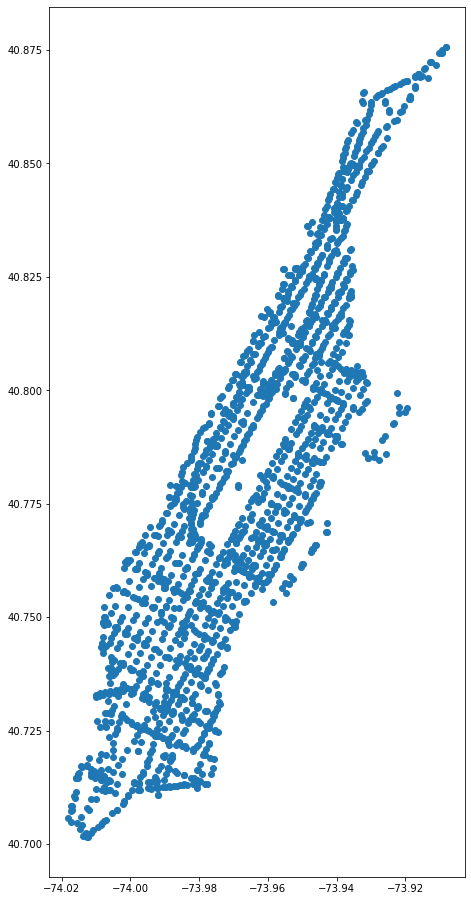

In [16]:
fig, ax = plt.subplots(figsize=(16, 16))
stops_gdf.plot(ax=ax)
plt.show()

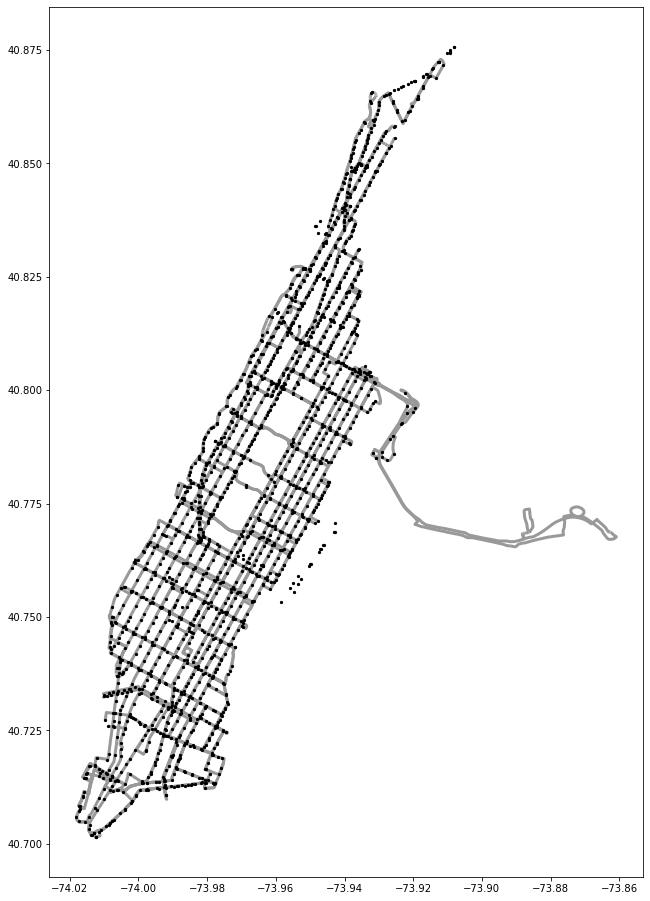

In [21]:
fig, ax = plt.subplots(figsize=(16, 16))
routes_gdf.plot(ax=ax, color='#999', zorder=1, linewidth=3)
stops_gdf.plot(ax=ax, color='#000', zorder=2, markersize=5)
plt.show()

In [83]:
route_mgs = []

for route_id in route_ids:
    route_mg = nx.read_shp(f'{EXPORTS_DIR}/shp/manhattan/routes/{route_id}.shp', simplify=False)
    route_mg.graph['crs'] = CRS_LATLON
    route_mgs.append(route_mg)

In [84]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [85]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    return edges_gdf

In [86]:
node_gdfs = [graph_to_node_gdf(route_mg) for route_mg in route_mgs]
edge_gdfs = [graph_to_edge_gdf(route_mg) for route_mg in route_mgs]

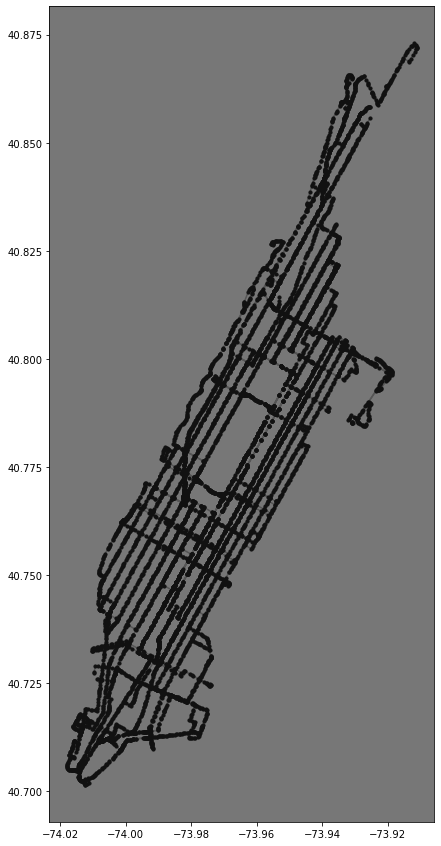

In [91]:
fig, ax = plt.subplots(figsize=(15, 15))
for edge_gdf in edge_gdfs:
    edge_gdf.plot(ax=ax, color='#555', zorder=1)
for node_gdf in node_gdfs:
    node_gdf.plot(ax=ax, markersize=10, color='#111', zorder=2)
ax.set_facecolor('#777')